<br><br>
<center><b>
    <font size="7">Face and Gender Detection</font>
    <br><br>
    <ins>Projet d'apprentissage automatique</ins><br>
    Réalisé par: Choubby Ibtissam, Harakat Meryem et Mouhoub Hiba
</b></center>
<br>

- <b>Objectif: </b>Développer un modèle de machine learning qui permet de détecter automatiquement le visage et le genre de la personne. <br>
- <b>Dataset: </b> [Images collectées à partir des sites IMDB et Wikipédia](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/)

# Data Pre-processing

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import cv2
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline 

### 1. Cropping images and putting them in a different folder (./data/crop)

In [2]:
# First we put images path in a list
femalePath = glob('./data/female/*.jpg')
malePath = glob('./data/male/*.jpg')

#### On va dans un premier temps voir le processus pour une seule image

In [3]:
test_PATH = femalePath[0]
test_image = cv2.imread(test_PATH)
test_image

array([[[196, 152, 135],
        [196, 152, 135],
        [196, 152, 135],
        ...,
        [251, 237, 239],
        [252, 238, 240],
        [251, 237, 239]],

       [[198, 154, 137],
        [198, 154, 137],
        [198, 154, 137],
        ...,
        [251, 237, 239],
        [252, 238, 240],
        [251, 237, 239]],

       [[199, 156, 141],
        [199, 156, 141],
        [199, 156, 141],
        ...,
        [251, 237, 239],
        [252, 238, 240],
        [252, 238, 240]],

       ...,

       [[253, 254, 252],
        [253, 254, 252],
        [253, 254, 252],
        ...,
        [139, 158, 195],
        [139, 158, 195],
        [139, 158, 195]],

       [[255, 255, 254],
        [255, 255, 254],
        [255, 255, 254],
        ...,
        [145, 164, 201],
        [147, 166, 203],
        [147, 166, 203]],

       [[252, 253, 251],
        [252, 253, 251],
        [252, 253, 251],
        ...,
        [143, 162, 199],
        [142, 161, 198],
        [142, 161, 198]]

Chaque image est représentée par une liste de arrays qui représentent la hauteur, la largeur et la profondeur des couleurs pour chaque pixel de la photo. Et vu que les images n'ont pas la même taille, la taille de la liste représentative diffère d'une image à une autre.<br> Les colorations dans la bibliothèque OpenCV est BGR et non RGB classique (qui est utilisée dans matplotlib). C'est la raison pour laquel les couleurs sont un peu bizarres dans le plot suivant:

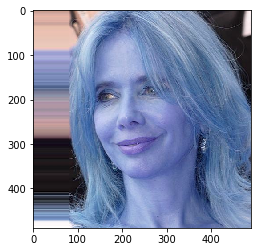

In [4]:
plt.imshow(test_image)

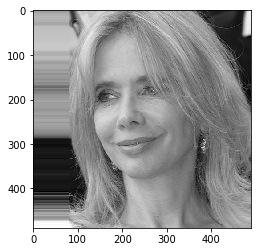

In [5]:
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')

La bibliothèque OpenCV fournit des modèles de detection de visage (et d'autres objets/animaux aussi) préalablement crées. Celui qu'on a utilisé est le front classifier (disponible dans le lien github suivant: https://github.com/opencv/opencv/tree/master/data/haarcascades)

In [6]:
# On instancie le modèle en premier
haar = cv2.CascadeClassifier('./model/front_classifier.xml')

In [7]:
# Ensuite on lui donne en paramètre l'image en question. 
# Le resultat sera les coordonnées du rectangle qui va encadrer le visage ainsi que sa hauteur et sa largeur
faces = haar.detectMultiScale(gray_image, 1.5 , 5)
print(faces)

[[ 86  86 273 273]]


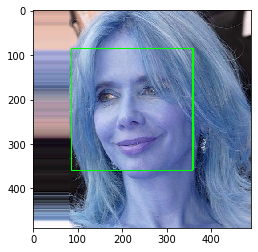

In [8]:
# Essayons de voir le resultat dans un plot
for x,y,w,h in faces:
    cv2.rectangle(test_image,(x,y),(x+w, y+h), (0,255,0),2)
plt.imshow(test_image)

Maintenant nous allons créer une fonction <b>extract_images(path, gender,i)</b> qui va automatiser ce processus pour ensuite l'appliquer à toutes les images de notre Dataset et enregistre les visages detectés dans un dossier séparé:

In [9]:
def extract_images(path, gender, i):
    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray,1.5,5)
    for x,y,w,h in faces:
        roi = image[x:x+w, y:y+h]
        if gender == 'male':
            cv2.imwrite('./data/crop/male_crop/{}_{}.png'.format(gender, i), roi)
        else:
            cv2.imwrite('./data/crop/female_crop/{}_{}.png'.format(gender, i), roi)

In [ ]:
for i, path in enumerate(femalePath):
    try:
        extract_images(path, 'female',i)
        print('INFO: {}/{} processed successfully'.format(i, len(femalePath)))
    except:
        print('WARNING: {}/{} wasnt processed'.format(i, len(femalePath)))

In [ ]:
for i, path in enumerate(malePath):
    try:
        extract_images(path, 'male',i)
        print('INFO: {}/{} processed successfully'.format(i, len(malePath)))
    except:
        print('WARNING: {}/{} wasnt processed'.format(i, len(malePath)))

### 2. Normalisation des images 

Les images recadrées ont été enregistrée dans le dossier <i>"./data/crop/(fe)male_crop"</i>. On va se baser sur celle-ci pour créer nos variables explicatives

In [10]:
female = glob('./data/crop/female_crop/*')
male = glob('./data/crop/male_crop/*')
path = female + male

#### On va dans un premier temps analyser puis normaliser la taille des images

Pour celà, on va utiliser la librairie pandas pour stockers nos données.
1. On crée les fonctions get_size(path) et gender(path) qui prennent en paramètre le chemin d'accès de l'image et retournent respectivement sa taille et le sexe de la personne
2. On crée un DataFrame avec une première colonne path 
3. Ensuite, on ajoute de nouvelles colonnes size et gender qu'on va générer à l'aide des fonctions.

In [11]:
def get_size(path):
    img = Image.open(path)
    return img.size[0]

def gender(string):
    try:
        return string.split('_')[0].split('/')[-1]
    except:
        None

In [12]:
df = pd.DataFrame(data=path, columns=['path'])
df['size'] = df['path'].apply(get_size)
df['gender'] = df['path'].apply(gender)

<b>Visualisation des données:</b>

In [13]:
import seaborn as sns 
sns.set()

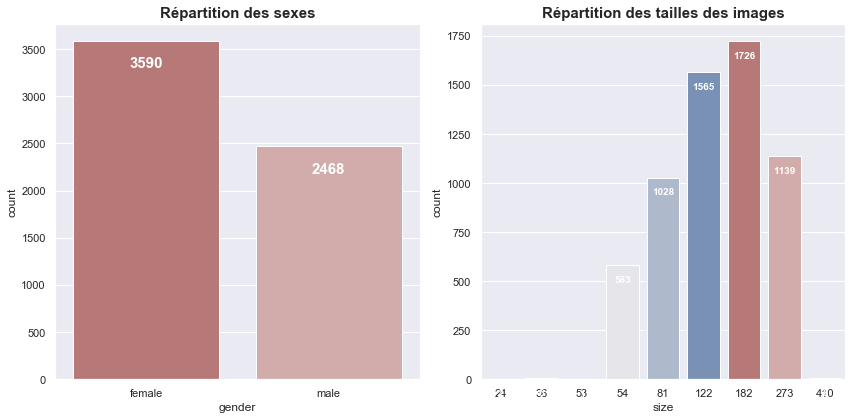

In [14]:
colors = sns.color_palette("vlag_r")
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
ax1.set_title('Répartition des sexes', fontsize=15, weight='bold')
sns.countplot( x='gender', data=df, palette=colors, ax=ax1)
for p in ax1.patches:
    ax1.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()),\
                 ha='center', va='top', color='white', size=15, weight='bold')


ax2 = fig.add_subplot(122)
ax2.set_title('Répartition des tailles des images', fontsize=15, weight='bold')
sns.countplot(data = df,x='size', palette=colors, ax=ax2)
for p in ax2.patches:
    ax2.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()),\
                 ha='center', va='top', color='white', size=10, weight='bold')

plt.close(2)
plt.close(3)
plt.tight_layout()

In [15]:
data= df[df['size']>54]
data

,path,size,gender
0,./data/crop/female_crop\female_0.png,273,female
1,./data/crop/female_crop\female_1.png,182,female
2,./data/crop/female_crop\female_100.png,182,female
3,./data/crop/female_crop\female_1003.png,182,female
4,./data/crop/female_crop\female_1008.png,81,female
...,...,...,...
6053,./data/crop/male_crop\male_989.png,182,male
6054,./data/crop/male_crop\male_99.png,273,male
6055,./data/crop/male_crop\male_991.png,122,male
6056,./data/crop/male_crop\male_995.png,182,male


Maintenant, on va créer une fonction resize_image(path) qui va prendre en paramètre le chemin d'accès d'une image et retourner un array qui représente l'image dans la taille standard (100x100). Ça va nous faire un total de 10000 variables explicatives. (Pas trop top je sais x))

In [16]:
def resize_image(path_to_resize):
    try:
        #step 1: read image
        img_to_resize = cv2.imread(path_to_resize)

        #step 2: convert into gray
        gray_to_resize = cv2.cvtColor(img_to_resize, cv2.COLOR_BGR2GRAY)

        #step 3: resize into 100x100
        size = gray_to_resize.shape[0]
        if size >= 100:
            resized_gray = cv2.resize(gray_to_resize,(100,100),cv2.INTER_AREA) #Shrink
        else:
            resized_gray = cv2.resize(gray_to_resize,(100,100),cv2.INTER_AREA) #Enlarge

        return resized_gray.flatten()
    except:
        return None

In [17]:
data['structured_data'] = data['path'].apply(resize_image)

In [18]:
features = data['structured_data'].apply(pd.Series)
new_data = pd.concat((data['gender'],features), axis=1)

In [19]:
new_data

,gender,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,female,188,180,184,188,173,179,192,178,216,...,109,111,115,116,122,116,119,120,117,111
1,female,15,15,17,18,17,16,16,14,18,...,175,165,177,194,194,197,194,191,182,171
2,female,8,10,18,20,9,16,7,16,16,...,168,177,170,181,171,174,178,161,164,167
3,female,59,63,66,68,65,61,57,56,51,...,90,82,79,84,90,92,106,147,162,148
4,female,52,55,67,67,49,53,63,62,48,...,161,158,153,150,149,151,153,144,130,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6053,male,34,33,31,33,32,31,32,32,31,...,37,25,42,34,184,61,24,41,33,20
6054,male,240,239,236,224,82,56,27,8,19,...,18,22,113,89,11,35,44,17,62,8
6055,male,36,50,76,113,167,206,204,199,197,...,51,42,32,28,27,25,25,26,25,24
6056,male,146,129,73,55,29,39,27,13,17,...,26,19,18,21,21,21,22,23,23,23


### 4. Netoyage des données 

#### Les valeurs manquantes

In [20]:
new_data.isna().sum()

gender    0
0         0
1         0
2         0
3         0
         ..
9995      0
9996      0
9997      0
9998      0
9999      0
Length: 10001, dtype: int64

#### Normalisation des données:  <br>$$Xnorm =  \frac {x - min}{max - min} $$   $$Ynorm=\begin{equation}
\left\{ 
  \begin{aligned}
    0 \text{ if } y = \textit{male}\\
    1 \text{ if } y = \textit{female}\\
  \end{aligned}
  \right.
\end{equation}
$$

In [21]:
X , Y = new_data.iloc[:,1:].values, new_data.iloc[:,0].values
Ynorm = np.where(Y=='female',1,0)
Xnorm = X/X.max()

### 5. Selection des variables explicatives: Analyse en Composantes Principales

In [22]:
from sklearn.decomposition import PCA

In [23]:
X1 = Xnorm - Xnorm.mean(axis = 0)
pca = PCA(n_components=None, whiten=True, svd_solver='auto')
Xpca = pca.fit_transform(X1)

In [24]:
eigen_ratio = pca.explained_variance_ratio_
eigen_ratio_cum = np.cumsum(eigen_ratio)

#### Critère du coude

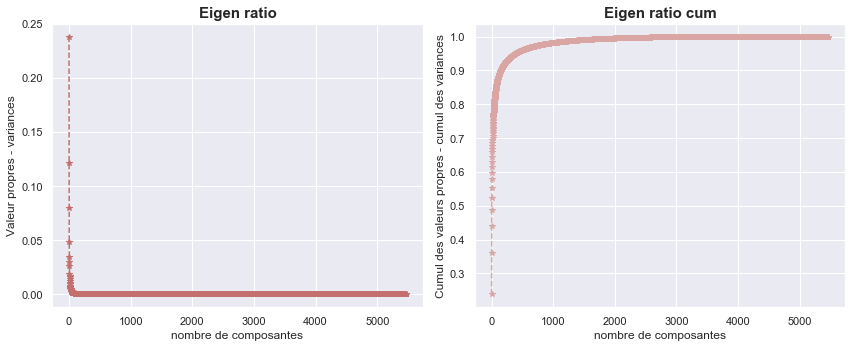

In [25]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
ax1.set_title('Eigen ratio', fontsize=15, weight='bold')
ax1.set_xlabel('nombre de composantes')
ax1.set_ylabel('Valeur propres - variances')
plt.plot(eigen_ratio,'*--',color=colors.as_hex()[0])


ax2 = fig.add_subplot(122)
ax2.set_title('Eigen ratio cum', fontsize=15, weight='bold')
ax2.set_xlabel('nombre de composantes')
ax2.set_ylabel('Cumul des valeurs propres - cumul des variances')
plt.plot(eigen_ratio_cum,'*--', color=colors.as_hex()[1])

plt.close(2)
plt.close(3)
plt.tight_layout()

la valeur propre associée à une variable explicative (également appelée axe) correspond à la fraction d’inertie qu’il retranscrit. Plus elle est élevée, plus cette variable est important dans la lecture des résultats.
Généralement, le point du coude est celui du nombre d'axes à partir duquel la variance ne se réduit plus significativement.
Les 2 plots ci-dessus ne sont pas très clairs vu le nombre d'axes utilisés (10000 axes).On peut déjà voir que le nombre d'axes significatif est moins que 100. Donc nous allons retracer les courbes pour 100 variables explicatives uniquement:

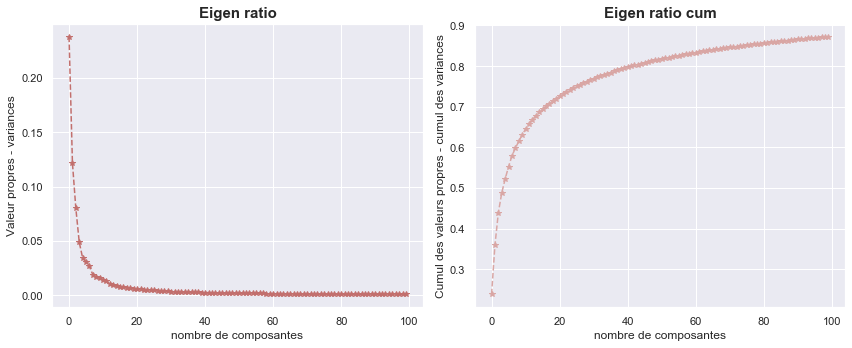

In [26]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
ax1.set_title('Eigen ratio', fontsize=15, weight='bold')
ax1.set_xlabel('nombre de composantes')
ax1.set_ylabel('Valeur propres - variances')
plt.plot(eigen_ratio[:100],'*--',color=colors.as_hex()[0])


ax2 = fig.add_subplot(122)
ax2.set_title('Eigen ratio cum', fontsize=15, weight='bold')
ax2.set_xlabel('nombre de composantes')
ax2.set_ylabel('Cumul des valeurs propres - cumul des variances')
plt.plot(eigen_ratio_cum[:100],'*--', color=colors.as_hex()[1])

plt.close(2)
plt.close(3)
plt.tight_layout()

On peut voire qu'à partir de 50 composantes, l'inertie perdue est presque nulle et le cumul des variances dépasse 80%.
Donc On va garder 50/10000 variables explicatives

In [27]:
pca_50 = PCA(n_components=50, whiten=True, svd_solver='auto')
Xpca50 = pca_50.fit_transform(X1)

#### Essayons de voir ce à quoi ressemble une images avec ses 10000 features vs avec 50 features uniquement:

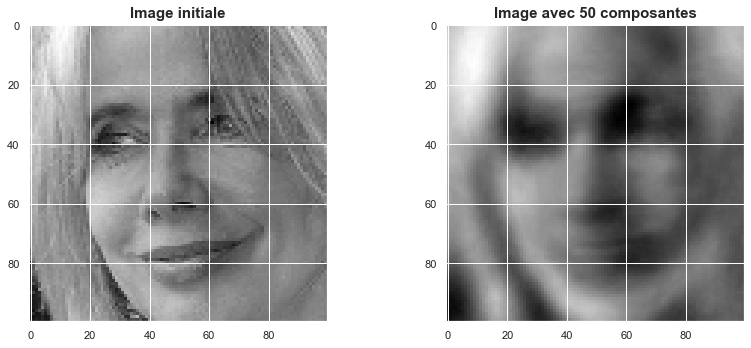

In [28]:
# xpca_inv ne contient que 50 variables. Le reste c'est des 0
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
ax1.set_title('Image initiale', fontsize=15, weight='bold')
xpca_inv_all = pca.inverse_transform(Xpca)
test_image = xpca_inv_all[0,:]
test_image = test_image.reshape((100,100))
plt.imshow(test_image, cmap='gray')


ax2 = fig.add_subplot(122)
ax2.set_title('Image avec 50 composantes', fontsize=15, weight='bold')
xpca_inv = pca_50.inverse_transform(Xpca50)
test_pca_image = xpca_inv[0,:]
test_pca_image = test_pca_image.reshape((100,100))
plt.imshow(test_pca_image, cmap='gray')


plt.close(2)
plt.close(3)
plt.tight_layout()


# Modèles d'apprentissage

### 1. Données d'apprentissage et de test 

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
final_X, final_Y, X_mean = Xpca50, Ynorm , X.mean(axis=0)

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(final_X,final_Y, test_size=0.2, stratify=final_Y)

### 2. Modèle SVC - Selection des hyperparamètres

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [33]:
model_tune = SVC()
pram_grid = {'C':[0.1,1,10,20,30,40,50], 
             'kernel':['rbf'],
             'gamma':[0.1,0.05,0.01,0.001]}

model_grid = GridSearchCV(model_tune, param_grid=pram_grid, scoring='accuracy', cv=5, verbose=1)
model_grid.fit(final_X, final_Y)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 20, 30, 40, 50],
                         'gamma': [0.1, 0.05, 0.01, 0.001], 'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [34]:
model_grid.best_params_

{'C': 1, 'gamma': 0.05, 'kernel': 'rbf'}

In [44]:
svc_model = SVC(C=1, kernel='rbf', gamma=0.05, probability=True)
svc_model.fit(X_train,Y_train)
svc_model.score(X_test, Y_test)

0.7577696526508226

### 3. XGBoost - Selection des hyperparamètres

In [36]:
from xgboost import XGBClassifier

In [37]:
mod = XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
     "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    'learning_rate': [0.1, 0.01, 0.05]
     }
model_grid_xgb = GridSearchCV(mod,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=5)
model_grid_xgb.fit(final_X, final_Y)

C:\Users\Mh\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:34:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [38]:
model_grid_xgb.best_params_

{'eta': 0.05, 'gamma': 0.0, 'learning_rate': 0.05}

In [39]:
xgb_model = XGBClassifier(eta=0.05, gamma=0.4, learning_rate=0.05)
xgb_model.fit(X_train,Y_train)
xgb_model.score(X_test, Y_test)

[16:34:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7605118829981719

### 3. Évaluation et comparaison des deux modèles

1. Matrice de confusion
2. Classification report: Accuracy, recall,precsion
3. Kappa score
4. ROC et AUC

In [45]:
ypred, ypred_proba = svc_model.predict(X_test), svc_model.predict_proba(X_test)
cm = metrics.confusion_matrix(Y_test, ypred)
acc = metrics.accuracy_score(Y_test, ypred)
recall = metrics.recall_score(Y_test, ypred)
precision = metrics.precision_score(Y_test, ypred)
kappa = metrics.cohen_kappa_score(Y_test, ypred)

In [46]:
ypred_xgb, ypred_proba_xgb = xgb_model.predict(X_test), xgb_model.predict_proba(X_test)
cm_xgb = metrics.confusion_matrix(Y_test, ypred_xgb)
acc_xgb = metrics.accuracy_score(Y_test, ypred_xgb)
recall_xgb = metrics.recall_score(Y_test, ypred_xgb)
precision_xgb = metrics.precision_score(Y_test, ypred_xgb)
kappa_xgb = metrics.cohen_kappa_score(Y_test, ypred_xgb)

In [47]:
results = pd.DataFrame({'accuracy':[acc, acc_xgb], 
                       'recall': [recall, recall_xgb],
                       'precision': [precision, precision_xgb],
                       'kappa score': [kappa, kappa_xgb]},
                      index = ['SVC','XGBoost'])
results

,accuracy,recall,precision,kappa score
SVC,0.757770,0.869632,0.759036,0.478971
XGBoost,0.760512,0.865031,0.764228,0.486613


Text(0, 0.5, 'True Positive Rate')

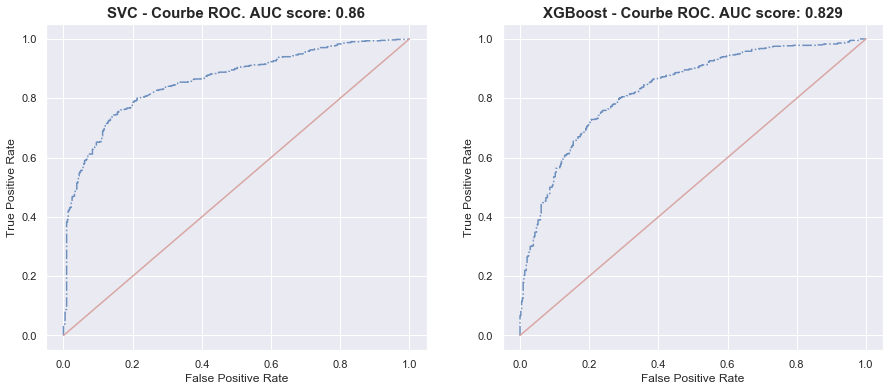

In [48]:
# Courbe ROC et AUC
fig = plt.figure(figsize=(15,6))

# SVC
fp, tp, thres = metrics.roc_curve(Y_test, ypred_proba[:,1])
auc_score = metrics.auc(fp, tp)

ax1 = fig.add_subplot(121)
ax1.set_title(f'SVC - Courbe ROC. AUC score: {round(auc_score,3)}', fontsize=15, weight='bold')
plt.plot(fp, tp,'-.', color=colors.as_hex()[5])
plt.plot([0,1],[0,1], color=colors.as_hex()[1])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

# XGBoost
fp_xgb, tp_xgb, thres_xgb = metrics.roc_curve(Y_test, ypred_proba_xgb[:,1])
auc_score_xgb = metrics.auc(fp_xgb, tp_xgb)

ax2 = fig.add_subplot(122)
ax2.set_title(f'XGBoost - Courbe ROC. AUC score: {round(auc_score_xgb,3)}', fontsize=15, weight='bold')
plt.plot(fp_xgb, tp_xgb,'-.', color=colors.as_hex()[5])
plt.plot([0,1],[0,1], color=colors.as_hex()[1])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
